In [1]:
%matplotlib inline

import ast
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator
from matplotlib.ticker import ScalarFormatter
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import matplotlib
import seaborn as sns
from itertools import groupby
from scipy import integrate
from tqdm import tqdm
import rasterio

plt.style.use('ggplot')
pd.set_option('chained_assignment',None)

sys.path.append(os.path.join( '..'))
from miriam_py.utils import load_config
data_path = load_config()['paths']['data']

## Creation of table with total length per infrastructure assets per income group

In [2]:
%%time
global_countries = gpd.read_file(os.path.join(data_path,'input_data','global_countries.shp'))
global_regions = gpd.read_file(os.path.join(data_path,'input_data','global_regions_v2.shp'))
prot_lookup = dict(zip(global_regions['GID_2'],global_regions['prot_stand']))
ne_countries = gpd.read_file(os.path.join(data_path,'input_data','ne_50m_admin_0_countries.shp'))
ne_sindex = ne_countries.sindex

incomegroups = pd.read_csv(os.path.join(data_path,'input_data','incomegroups_2018.csv'),index_col=[0])

Wall time: 9.2 s


In [3]:
tot_roads = pd.read_feather(os.path.join(data_path,'summarized','all_road_stats.ft'))
#tot_roads = tot_roads.loc[tot_roads.road_type.isin(['primary','secondary','tertiary'])]
tot_roads = tot_roads.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_roads = tot_roads.merge(incomegroups,left_on='country',right_on='CountryCode')
#tot_roads['GroupName'] = tot_roads.country.apply(lambda x : wbregion(x)) 
tot_len_road = pd.DataFrame(tot_roads.groupby(['GroupCode','road_type'])['length'].sum(),columns=['length'])

In [4]:
rail_to_remove =['disused','abandoned','dismantled','preserved', 'proposed','razed', 
                 'planned','no','historical','na','not_built','abandonned', 'uncompleted', 'demolished',
                 'abandoned_tram','construction;rail', 'rail;construction','waste_disposal','collapsed']

tot_rail = pd.read_feather(os.path.join(data_path,'summarized','all_railway_stats.ft'))
tot_rail = tot_rail.loc[~(tot_rail.infra_type.isin(rail_to_remove))]

tot_rail = tot_rail.merge(global_countries[['ISO_3digit','wbincomena']],left_on='country',right_on='ISO_3digit')
tot_rail = tot_rail.merge(incomegroups,left_on='country',right_on='CountryCode')
#tot_rail['GroupName'] = tot_rail.country.apply(lambda x : wbregion(x)) 

tot_len_rail = pd.DataFrame(tot_rail.groupby('GroupCode')['length'].sum(),columns=['length'])
tot_len_rail['road_type'] = 'Railway'

In [5]:
%%time
bridges_ro = pd.read_csv(os.path.join(data_path,'summarized','bridges_summary_stats.csv'))
bridges_ro = bridges_ro.loc[~(bridges_ro.rail_type.notnull())]
bridges_ro = bridges_ro.drop(['Unnamed: 0','Unnamed: 0.1','geometry'],axis=1)
bridges_ro = bridges_ro.merge(incomegroups,left_on='country',right_on='CountryCode')
bridges_ra = pd.read_csv(os.path.join(data_path,'summarized','rail_bridges_summary_stats.csv'))
bridges_ra = bridges_ra.merge(incomegroups,left_on='country',right_on='CountryCode')

tot_len_br_ro = pd.DataFrame(bridges_ro.groupby('GroupCode')['length'].sum(),columns=['length'])/1000
tot_len_br_ro['road_type'] = 'Road Bridges'
tot_len_br_ra = pd.DataFrame(bridges_ra.groupby('GroupCode')['length'].sum(),columns=['length'])/1000
tot_len_br_ra['road_type'] = 'Railway Bridges'

<string>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 24.4 s


In [6]:
all_length = pd.concat([tot_len_road.reset_index(level=1),tot_len_rail,tot_len_br_ro,tot_len_br_ra],sort=False).reset_index().groupby(['GroupCode','road_type']).sum().unstack(1)
all_length.to_csv('income_infra_length.csv')

## Creation of bridge fragility curve figure

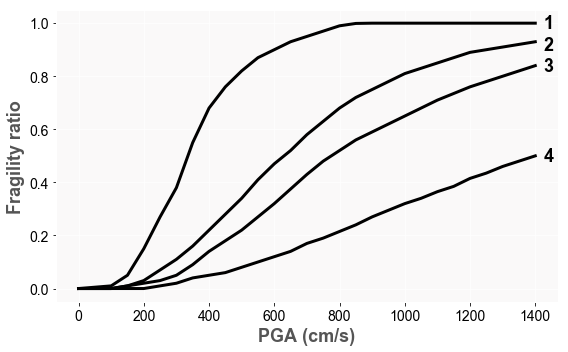

In [31]:
bridge_curves = pd.read_excel(os.path.join(data_path,'input_data','Costs_curves.xlsx'),sheet_name='bridge_curves')
fig,ax = plt.subplots(1,1,figsize = (8,5))

color_scheme = ['#13293D','#006494','#247BA0','#1B98E0'] #['#bae4bc','#7bccc4','#43a2ca','#0868ac']
cmap = LinearSegmentedColormap.from_list(name='continents',
                                     colors=color_scheme)  


bridge_curves.plot(ax=ax,linewidth=3,color='black',legend=False)

ax.set_facecolor('#FAF9F9')
ax.set_xlabel('PGA (cm/s)',fontweight='bold',fontsize=18)
ax.set_ylabel('Fragility ratio',fontweight='bold',fontsize=18)
ax.tick_params(axis = 'both',labelsize=14,labelcolor='black',color='black')

ax.text(1425, 0.98, '1',fontweight="bold",color='black', fontsize=18)
ax.text(1425, 0.9, '2',fontweight="bold",color='black', fontsize=18)
ax.text(1425, 0.82, '3',fontweight="bold",color='black', fontsize=18)
ax.text(1425, 0.48, '4',fontweight="bold",color='black', fontsize=18)

fig.tight_layout()
fig.savefig(os.path.join(data_path,'Figures','Bridge_fragility_curves.png'),dpi=300)



## Creation of flood road fragility curve figure

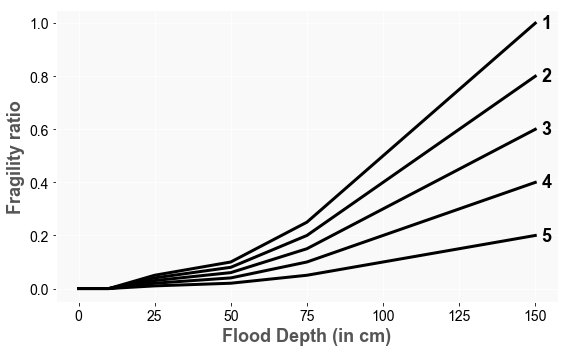

In [34]:
fig,ax = plt.subplots(1,1,figsize = (8,5))


color_scheme = ['#13293D','#006494','#247BA0','#1B98E0'] #['#bae4bc','#7bccc4','#43a2ca','#0868ac']
cmap = LinearSegmentedColormap.from_list(name='continents',
                                         colors=color_scheme)  
paved_curves = pd.read_excel(os.path.join(data_path,'input_data','Costs_curves.xlsx'),sheet_name='flood_curve_paved')
paved_curves.plot(ax=ax,linewidth=3,color='black',legend=False)

ax.set_facecolor('#FAF9F9')
ax.set_xlabel('Flood Depth (in cm)',fontweight='bold',fontsize=18)
ax.set_ylabel('Fragility ratio',fontweight='bold',fontsize=18)
ax.tick_params(axis = 'both',labelsize=14,labelcolor='black',color='black')
ax.set_xticks(np.arange(0,151,25))


ax.text(152, 0.98, '1',fontweight="bold",color='black', fontsize=18)
ax.text(152, 0.78, '2',fontweight="bold",color='black', fontsize=18)
ax.text(152, 0.58, '3',fontweight="bold",color='black', fontsize=18)
ax.text(152, 0.38, '4',fontweight="bold",color='black', fontsize=18)
ax.text(152, 0.18, '5',fontweight="bold",color='black', fontsize=18)

fig.tight_layout()
fig.savefig(os.path.join(data_path,'Figures','Flood_fragility_curves.png'),dpi=300)

## Creation of global liquefaction map

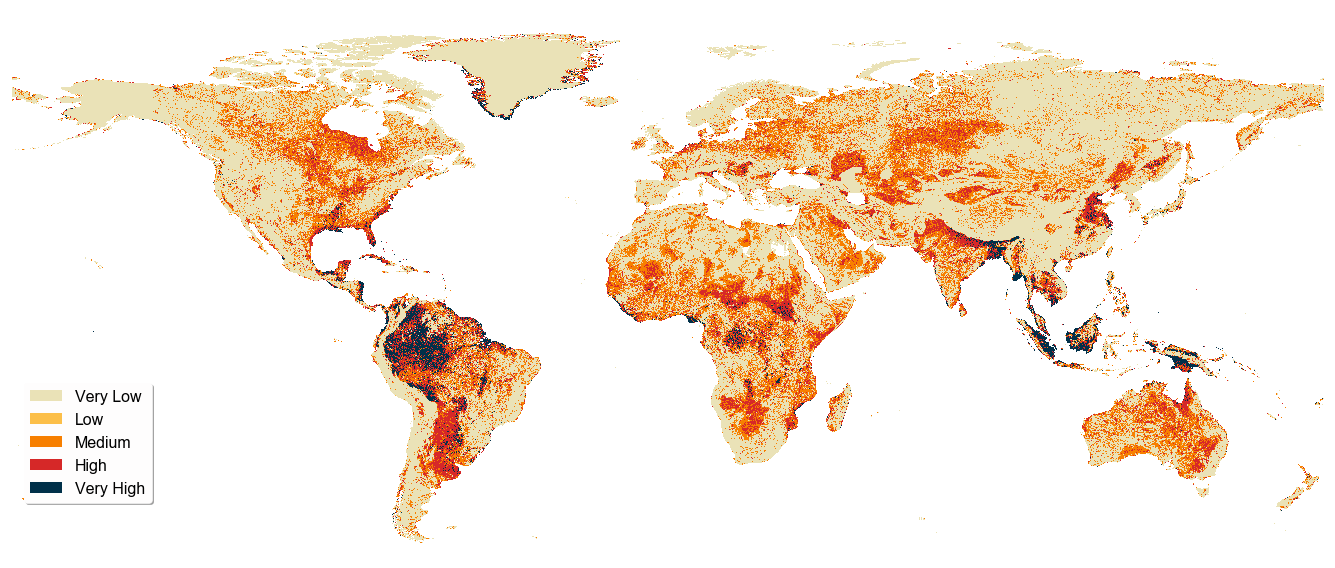

In [9]:
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot

countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
raster = rasterio.open(os.path.join(data_path,'hazards','Liquefaction','Global','liquefaction_v1_deg.tif'))

color_scheme = ['white','#EAE2B7','#FCBF49','#F77F00','#D62828','#003049'] 
cmap = LinearSegmentedColormap.from_list(name='continents',
                                         colors=color_scheme)  

fig, ax = plt.subplots(1, 1,figsize=(20,8))
rasterio.plot.show(raster, ax=ax,cmap=cmap)
#countries.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=0.3)


ax.set_ylim(-60, 90)

ax.set_xticks([])
ax.set_yticks([])

ax.patch.set_facecolor('white')

legend_elements = [Patch(facecolor=color_scheme[1],label='Very Low'),
                  Patch(facecolor=color_scheme[2],label='Low'),
                  Patch(facecolor=color_scheme[3],label='Medium'),
                  Patch(facecolor=color_scheme[4],label='High'),
                   Patch(facecolor=color_scheme[5],label='Very High')]
                   
ax.legend(handles=legend_elements,edgecolor='#fefdfd',facecolor='#fefdfd',
          prop={'size':16},loc=(0.01,0.1), shadow=True, fancybox=True)

fig.tight_layout()
fig.savefig(os.path.join(data_path,'Figures','Global_Liquefaction_Map.png'),dpi=300)

## Creation of file with country length values

In [10]:
road_length_country = tot_roads.groupby(['country','road_type'])['length'].sum().unstack(1)
rail_length_country = pd.DataFrame(tot_rail.groupby('country')['length'].sum())
rail_length_country.columns = ['railway']
br_ro_length_country = pd.DataFrame(bridges_ro.groupby('country')['length'].sum())/1000
br_ro_length_country.columns = ['road_bridges']
br_ra_length_country = pd.DataFrame(bridges_ra.groupby('country')['length'].sum())/1000
br_ra_length_country.columns = ['railway_bridges']

In [11]:
country_file = pd.concat([road_length_country,rail_length_country,br_ro_length_country,br_ra_length_country],axis=1,sort=False)
country_file = country_file.drop('nodata',axis=1).fillna(0).astype(int)

In [12]:
global_countries = gpd.read_file(os.path.join(data_path,'input_data','global_countries.shp'))
name_lookup = dict(zip(global_countries['GID_0'],global_countries['NAME_0']))

In [13]:
country_file = country_file.merge(global_countries[['ISO_3digit','NAME_0','SIDS']],left_index=True,right_on='ISO_3digit')
country_file = country_file.groupby('NAME_0').sum()

In [14]:
((country_file[['primary','secondary']].sum(axis=1)/country_file.sum(axis=1)).sort_values(ascending=False)*100).mean()

15.843003632783864

In [15]:
SIDS = country_file.loc[country_file.SIDS == 1]
((SIDS[['primary','secondary']].sum(axis=1)/SIDS.sum(axis=1)).sort_values(ascending=False)*100).mean()

14.78622142140545